# Supervised Learning: Random Forest Regression

## Authors: Kyle Sung, James Cheng, Saffron Magoon, Lucas Merla

In [1]:
from src.utils import load_dataframe
from src.constants import DATA_DIR

df = load_dataframe(DATA_DIR / "data_cleaned_PersonalProperty_encoded.csv")
df.head()

Data loaded successfully.


,student_id,name,class,gpa,is_greek,is_on_campus,distance_to_campus,is_female,is_sprinklered,claim_id,amount,risk_tier,holdout,Business,Humanities,Other,Science
0,1,"Saiz, Leslie",3,1.203913,0,0,0.000000,0.0,1,0,0.0,2,0,0,1,0,0
1,2,"Reddy, Dawna",3,0.609616,0,0,0.000000,1.0,1,0,0.0,2,0,0,0,0,1
2,3,"Rivera, Johnna",3,3.073385,0,1,0.223942,1.0,0,0,0.0,2,0,1,0,0,0
3,4,"al-Jamil, Umaira",4,3.224736,0,0,0.000000,0.0,0,0,0.0,3,0,1,0,0,0
4,5,"el-Mohammed, Qutb",2,2.687851,0,0,0.000000,1.0,0,0,0.0,1,0,1,0,0,0


In [2]:
# Separate the data into train and test sets based on the 'holdout' column
train_df = df[df["holdout"] == 0]
test_df = df[df["holdout"] == 1]

# Drop the 'holdout' column from the train and test sets
train_df = train_df.drop(
    columns=["holdout", "student_id", "name", "claim_id", "is_female"]
)
test_df = test_df.drop(
    columns=["holdout", "student_id", "name", "claim_id", "is_female"]
)

print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (8070, 12)
Test set shape: (1981, 12)


We will set up models to predict both the risk tier (to understand the previous decisions of the underwriters) and the amount (to make pricing decisions).

In [3]:
X_train = train_df.drop(columns=["risk_tier", "amount"]).to_numpy()
y_train_risk_tier = train_df[["risk_tier"]].to_numpy().reshape(-1, 1)
y_train_amount = train_df[["amount"]].to_numpy().reshape(-1, 1)

X_test = test_df.drop(columns=["risk_tier", "amount"]).to_numpy()
y_test_risk_tier = test_df[["risk_tier"]].to_numpy().reshape(-1, 1)
y_test_amount = test_df[["amount"]].to_numpy().reshape(-1, 1)

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from src.constants import SEED

rf_amount = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf_amount.fit(X_train, y_train_amount.ravel())
y_pred_amount = rf_amount.predict(X_test)

train_rmse_amount = np.sqrt(
    mean_squared_error(y_train_amount, rf_amount.predict(X_train))
)
test_rmse_amount = np.sqrt(mean_squared_error(y_test_amount, y_pred_amount))

print(f"Train Mean Squared Error (Amount): {train_rmse_amount}")
print(f"Test Mean Squared Error (Amount): {test_rmse_amount}")

Train Mean Squared Error (Amount): 160.99527564941985
Test Mean Squared Error (Amount): 379.61306183077124


In [5]:
from src.model_utils import pickle_sk_model
from src.constants import MODEL_DIR

pickle_sk_model(rf_amount, MODEL_DIR / "rf_amount_model.pkl")

Model saved.


In [6]:
rf_risk_tier = RandomForestRegressor(n_estimators=100, random_state=SEED)
rf_risk_tier.fit(X_train, y_train_risk_tier.ravel())
y_pred_risk_tier = rf_risk_tier.predict(X_test)

train_rmse_risk_tier = np.sqrt(
    mean_squared_error(y_train_risk_tier, rf_risk_tier.predict(X_train))
)
test_rmse_risk_tier = np.sqrt(mean_squared_error(y_test_risk_tier, y_pred_risk_tier))

print(f"Train Mean Squared Error (Risk Tier): {train_rmse_risk_tier}")
print(f"Test Mean Squared Error (Risk Tier): {test_rmse_risk_tier}")

Train Mean Squared Error (Risk Tier): 0.0
Test Mean Squared Error (Risk Tier): 0.0


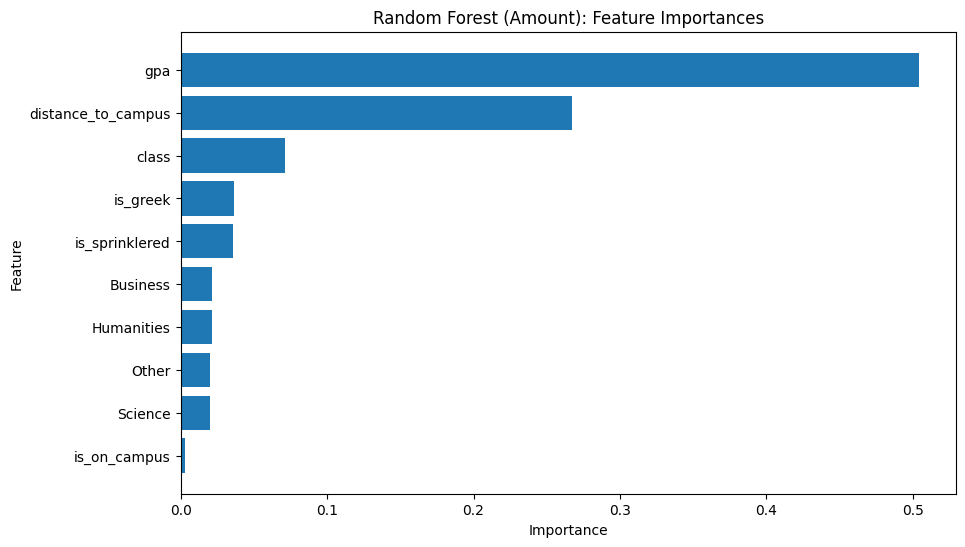

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import IMG_DIR

importances = rf_amount.feature_importances_

feature_names = train_df.drop(columns=["risk_tier", "amount"]).columns
feature_importances = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
)
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest (Amount): Feature Importances")
plt.gca().invert_yaxis()
plt.savefig(IMG_DIR / "RF_amount_feature_importances.png", bbox_inches="tight")
plt.show()

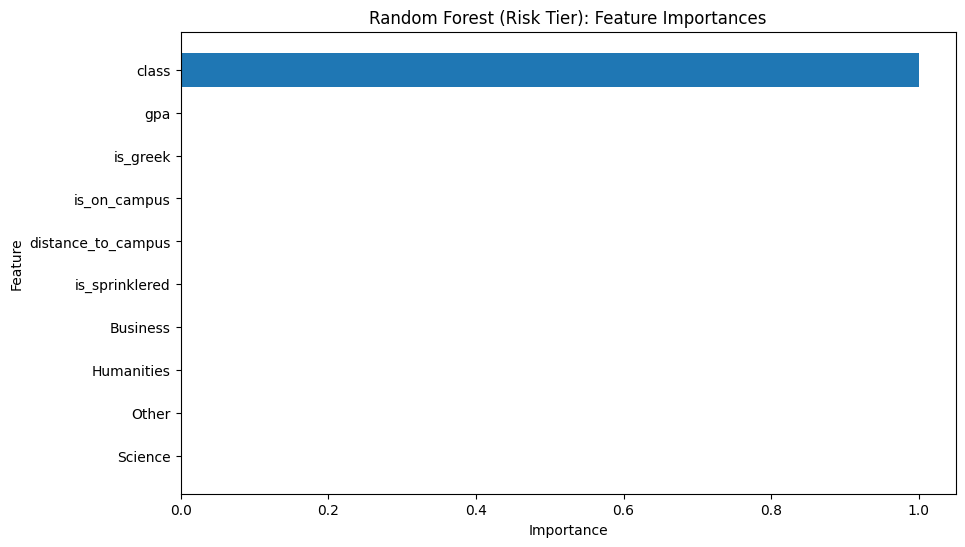

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import IMG_DIR

importances = rf_risk_tier.feature_importances_

feature_names = train_df.drop(columns=["risk_tier", "amount"]).columns
feature_importances = pd.DataFrame(
    {"Feature": feature_names, "Importance": importances}
)
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest (Risk Tier): Feature Importances")
plt.gca().invert_yaxis()
plt.savefig(IMG_DIR / "RF_risk_tier_feature_importances.png", bbox_inches="tight")
plt.show()

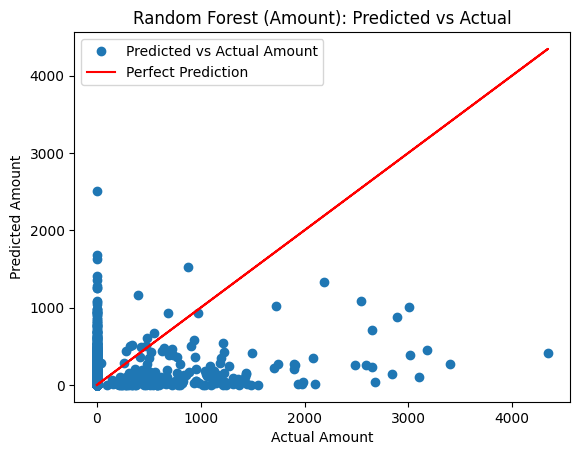

In [9]:
plt.plot(y_test_amount, y_pred_amount, "o", label="Predicted vs Actual Amount")
plt.plot(y_test_amount, y_test_amount, "r-", label="Perfect Prediction")
plt.xlabel("Actual Amount")
plt.ylabel("Predicted Amount")
plt.title("Random Forest (Amount): Predicted vs Actual")
plt.legend()
plt.savefig(IMG_DIR / "RF_amount_predicted_vs_actual.png", bbox_inches="tight")
plt.show()